In [1]:
import sys 
sys.path.append('../../')

%load_ext autoreload
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, Grayscale
from torchvision.datasets import MNIST, CIFAR10 
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import pandas as pd

%autoreload 2
from networks import *
from utils import *
from losses import *
from landscape import *
from datasets import *

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

/home/dekape/miniconda3/lib/python3.7/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /home/dekape/miniconda3/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZNK2at10TensorBase21__dispatch_contiguousEN3c1012MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


## Training Setup

In [2]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)


# Set training static parameters and hyperparameters
nepochs=100
dims_latent = 32                            
learning_rate=1e-3
batch_size=16                                        
device=set_device("cuda", 0)
train_size=0.7

# Losses
l2loss    = nn.MSELoss(reduction="sum")
awloss     = AWLoss(filter_dim=1, method="fft", reduction="sum", std=3e-4, store_filters="norm", epsilon=3e-15)


Cuda installed! Running on GPU 0 NVIDIA GeForce RTX 2080 Ti!


UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

Using cache found in /home/dekape/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


(256, 320, 320)
(256, 320, 320)


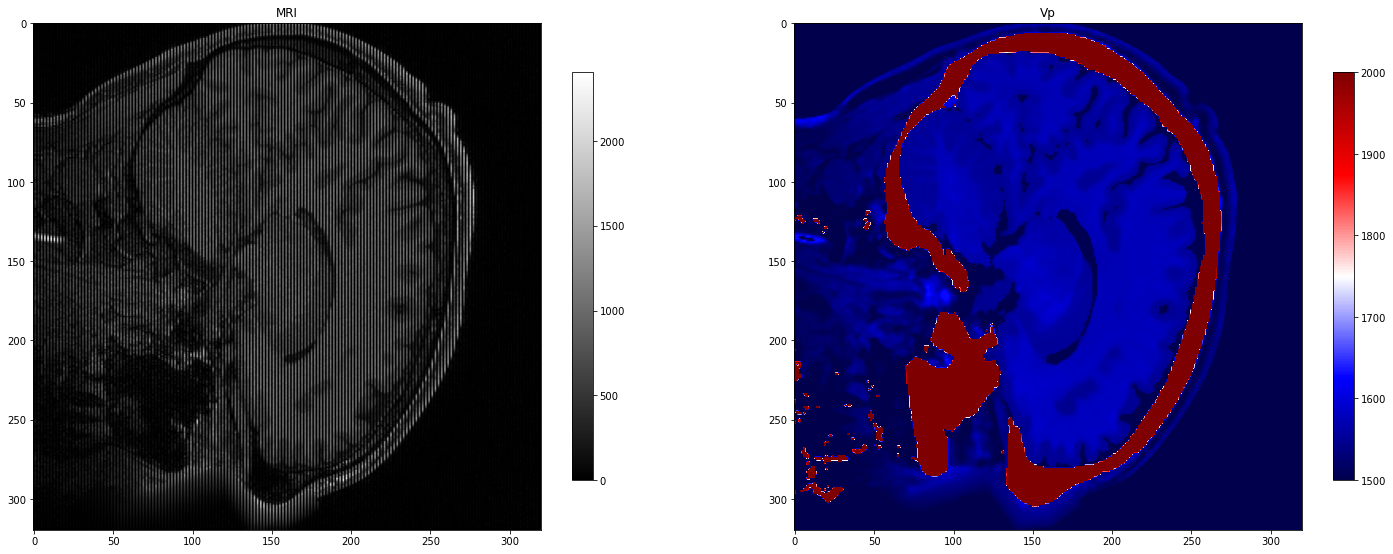

In [19]:
path = "../data/ultrasound/m100206_T1w.npy"
mri = np.load(path)
mri[:,:,::2] = 0.
print(mri.shape)

path = "../data/ultrasound/Vp.npy"
vp = np.load(path)
print(vp.shape)

idx = 150
fig, axs = plt.subplots(1,2, figsize=(25,25))

im = axs[0].imshow(mri[idx,:,:], cmap="gray")
fig.colorbar(im, ax=axs[0], shrink=0.3)
axs[0].set_title("MRI")

im = axs[1].imshow(vp[idx,:,:], vmin=1500, vmax=2000, cmap="seismic")
fig.colorbar(im, ax=axs[1], shrink=0.3)
axs[1].set_title("Vp")
plt.show()

In [7]:
# df = px.data.iris()
# # print(df)
# s = 8
# scaled = vp[::s,::s,::s]
# print(scaled.shape)
# plt.imshow(scaled[16, :, :])
# plt.show()
# arr = [np.arange(0, i, 1) for i in scaled.shape]
# X, Y, Z = np.meshgrid(arr[0], arr[1], arr[2])

# fig = go.Figure(data=go.Volume(
#     x=X.flatten(),
#     y=Y.flatten(),
#     z=Z.flatten(),
#     value=scaled.flatten(),
#     isomin=1500,
#     isomax=2000,
#     opacity=0.1, # needs to be small to see through all surfaces
#     surface_count=17, # needs to be a large number for good volume rendering
#     ))
# fig.show()